In [342]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
from nltk.probability import FreqDist
import nltk

import re
import string
from num2words import num2words
import csv
import numpy as np
from terbilang import Terbilang
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud

In [270]:
t = Terbilang()

In [271]:
df = pd.read_csv('asset_challenge/data.csv', encoding='latin-1')
df.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [272]:
df = df[['Tweet']]
df.head()

,Tweet
0,- disaat semua cowok berusaha melacak perhatia...
1,RT USER: USER siapa yang telat ngasih tau elu?...
2,"41. Kadang aku berfikir, kenapa aku tetap perc..."
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...
4,USER USER Kaum cebong kapir udah keliatan dong...


## drop duplicated

In [273]:
df.duplicated().sum()

146

In [274]:
df.shape

(13169, 1)

In [275]:
# delete duplicate data
df = df.drop_duplicates()
df.shape

(13023, 1)

In [276]:
df.head()

,Tweet
0,- disaat semua cowok berusaha melacak perhatia...
1,RT USER: USER siapa yang telat ngasih tau elu?...
2,"41. Kadang aku berfikir, kenapa aku tetap perc..."
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...
4,USER USER Kaum cebong kapir udah keliatan dong...


### check missing value

In [277]:
df.isna().sum()

Tweet    0
dtype: int64

dari hasil diatas diketahui bahwa tidak terdapat missing value pada data

## merubah text menjadi huruf kecil

In [278]:
# merubah kalimat menjadi huruf kecil

def clean_text(text):
  text = text.lower()
  return text

In [279]:
df['text_lower'] = df['Tweet'].apply(lambda x: ' '.join([clean_text(word) for word in x.split()]))
# df.drop('text', axis=1, inplace=True)
df

,Tweet,text_lower
0,- disaat semua cowok berusaha melacak perhatia...,- disaat semua cowok berusaha melacak perhatia...
1,RT USER: USER siapa yang telat ngasih tau elu?...,rt user: user siapa yang telat ngasih tau elu?...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...","41. kadang aku berfikir, kenapa aku tetap perc..."
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,user user aku itu aku\n\nku tau matamu sipit t...
4,USER USER Kaum cebong kapir udah keliatan dong...,user user kaum cebong kapir udah keliatan dong...
...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,user jangan asal ngomong ndasmu. congor lu yg ...
13165,USER Kasur mana enak kunyuk',user kasur mana enak kunyuk'
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,user hati hati bisu :( .g\n\nlagi bosan huft \...
13167,USER USER USER USER Bom yang real mudah terdet...,user user user user bom yang real mudah terdet...


## proses pembersihan data

In [280]:
def remove_unnecessary_char(text):
    text = re.sub(r'\\+n', ' ', text)
    text = re.sub('user', ' ', text)  # remove every username
    text = re.sub(r'\n', " ", text)  # remove every '\n'
    text = re.sub(r'(rt)', ' ', text)  # remove every retweet symbol
    text = re.sub(r'\\x.{2}', ' ', text)  # remove emoji
    text = ' '.join([re.sub('\d{1,}\,\d{1,}', lambda x: t.parse(
        word).getresult(), word) for word in text.split()])  # terbilang
    text = ' '.join([re.sub(
        '\d{1,4}', lambda m: num2words(int(m.group()), lang='id'), word) for word in text.split()])
    # remove every URL
    text = re.sub(
        r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', ' ', text)
    text = re.sub(r'&amp;', 'dan', text)  # remove ampersant
    text = re.sub(r'&', 'dan', text)  # remove ampersant
    # remove phone number +6282xxxxxxxxx
    text = re.sub(r'\+62\d{2,}', ' ', text)
    # remove phone number +628xx-xxxx-xxxx
    text = re.sub('[\+\d{5}\-\d{4}\-\d{4}]', ' ', text)

    text = re.sub(r'%', ' persen ', text)  # change % to persen
    text = re.sub('[%s]' % re.escape(string.punctuation),
                  ' ', text)  # remove punctuation

    text = re.sub(r'[^a-z ]', ' ', text)  # remove another word
    text = re.sub(r'  +', ' ', text)  # remove extra spaces
    text = text.rstrip().lstrip()  # remove rstrip and lstrip

    return text

In [281]:
df_kamusalay = pd.read_csv('asset_challenge/new_kamusalay.csv', encoding='latin-1', names=['find', 'replace'])


kamusalay_mapping = dict(zip(df_kamusalay['find'], df_kamusalay['replace'])) # Mapping for kamusalay


def handle_from_kamusalay(text): # Cleaning by replacing 'alay' words
    wordlist = text.split()
    text_clean = ' '.join([kamusalay_mapping.get(x,x) for x in wordlist])
    return text_clean

In [282]:
# drop text column
df.drop(['Tweet'], axis=1, inplace=True)
# cleaning karakter
df['text_clean'] = df['text_lower'].apply(
    lambda x: remove_unnecessary_char(x))
# apply kamusalay function
df['text'] = df['text_clean'].apply(lambda x: handle_from_kamusalay(x))
# drop text clean column
df.drop(['text_lower', 'text_clean'], axis=1, inplace=True)

df.head()

,text
0,di saat semua cowok berusaha melacak perhatian...
1,siapa yang telat memberi tau kamu edan sarap g...
2,empat puluh satu kadang aku berpikir kenapa ak...
3,aku itu aku ku tau matamu sipit tapi dilihat d...
4,kaum cebong kafir sudah kelihatan dongoknya da...


## filtering stopwords

In [283]:
stop_words = set(stopwords.words('indonesian'))

def stopword_cleansing(text):
    word_tokens = word_tokenize(text) 
    stopword_text_clean = ' '.join([w for w in word_tokens if not w in stop_words])
    return stopword_text_clean

In [284]:
df['stopword_clean'] = df['text'].apply(lambda x: stopword_cleansing(x))
df.head()

,text,stopword_clean
0,di saat semua cowok berusaha melacak perhatian...,cowok berusaha melacak perhatian gue lantas re...
1,siapa yang telat memberi tau kamu edan sarap g...,telat tau edan sarap gue bergaul cigax jifla c...
2,empat puluh satu kadang aku berpikir kenapa ak...,puluh kadang berpikir percaya tuhan jatuh berk...
3,aku itu aku ku tau matamu sipit tapi dilihat d...,ku tau matamu sipit
4,kaum cebong kafir sudah kelihatan dongoknya da...,kaum cebong kafir dongoknya dungu haha


## stemming bahasa indonesia

In [285]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemming process
def stemming_indonesian_text(text):
    output = stemmer.stem(text)
    return output

In [286]:
# menjalankan fungsi stemming
df['stemming_text'] = df['stopword_clean'].apply(lambda x: stemming_indonesian_text(x))
df.head()

,text,stopword_clean,stemming_text
0,di saat semua cowok berusaha melacak perhatian...,cowok berusaha melacak perhatian gue lantas re...,cowok usaha lacak perhati gue lantas remeh per...
1,siapa yang telat memberi tau kamu edan sarap g...,telat tau edan sarap gue bergaul cigax jifla c...,telat tau edan sarap gue gaul cigax jifla cal ...
2,empat puluh satu kadang aku berpikir kenapa ak...,puluh kadang berpikir percaya tuhan jatuh berk...,puluh kadang pikir percaya tuhan jatuh kali ka...
3,aku itu aku ku tau matamu sipit tapi dilihat d...,ku tau matamu sipit,ku tau mata sipit
4,kaum cebong kafir sudah kelihatan dongoknya da...,kaum cebong kafir dongoknya dungu haha,kaum cebong kafir dongok dungu haha


## distribusi frekuensi kata yang dominan muncul

In [287]:
# Pertama kita lakukan tokenization pada dataset kita

df['tweet'] = df['stemming_text'].apply(lambda x: word_tokenize(str(x)

# Setelah itu kita masukkan pada semua token tersebut pada satu list yang sama 
tweets = [word for tweet in df['tweet'] for word in tweet]
 
# Kita akan memanfaatkan library freqdist yang dimiliki oleh NLTK
fqdist = FreqDist(tweets)

print(fqdist)


<FreqDist with 13824 samples and 147901 outcomes>


In [288]:
# Untuk mengetahui kata dan jumlah dari masing-masing kata kita bisa menggunakan.
most_common_word = fqdist.most_common(20)

print(most_common_word)

[('indonesia', 1645), ('orang', 1327), ('ribu', 1288), ('ya', 1196), ('gue', 1185), ('presiden', 1128), ('jokowi', 1081), ('sembilan', 957), ('puluh', 885), ('islam', 882), ('uniform', 830), ('resource', 830), ('locator', 830), ('sih', 816), ('agama', 816), ('belas', 793), ('pilih', 749), ('asing', 739), ('komunis', 722), ('rakyat', 703)]


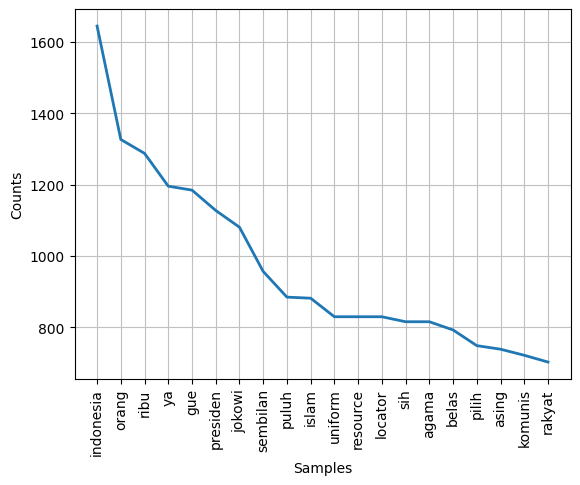

In [289]:
# visualisasi kata yang sering keluar
fqdist.plot(20,cumulative=False)
plt.show()

In [290]:
result = pd.Series(nltk.ngrams(tweets, 2)).value_counts()[:20]
result

(uniform, resource)               830
(resource, locator)               830
(ribu, sembilan)                  726
(komunis, indonesia)              366
(partai, komunis)                 360
(sembilan, belasgantipresiden)    340
(kepala, daerah)                  330
(pilih, kepala)                   325
(delapan, belas)                  310
(ribu, delapan)                   294
(sepe, i)                         230
(wakil, rakyat)                   229
(dewan, wakil)                    212
(sembilan, belas)                 209
(republik, indonesia)             167
(tenaga, kerja)                   154
(susilo, bambang)                 151
(bambang, yudhoyono)              151
(berantas, korupsi)               146
(komisi, berantas)                142
dtype: int64

# Analisis kata alay pada media sosial

In [291]:
df = pd.read_csv('asset_challenge/data.csv', encoding='latin-1')
df.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [292]:
df = df[['Tweet']]
df.head()

,Tweet
0,- disaat semua cowok berusaha melacak perhatia...
1,RT USER: USER siapa yang telat ngasih tau elu?...
2,"41. Kadang aku berfikir, kenapa aku tetap perc..."
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...
4,USER USER Kaum cebong kapir udah keliatan dong...


In [293]:
# merubah kalimat menjadi huruf kecil

def lower_text(text):
  text = text.lower()
  return text

In [294]:
df['lower_text'] = df['Tweet'].apply(lambda x: lower_text(x))
df.head()

,Tweet,lower_text
0,- disaat semua cowok berusaha melacak perhatia...,- disaat semua cowok berusaha melacak perhatia...
1,RT USER: USER siapa yang telat ngasih tau elu?...,rt user: user siapa yang telat ngasih tau elu?...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...","41. kadang aku berfikir, kenapa aku tetap perc..."
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,user user aku itu aku\n\nku tau matamu sipit t...
4,USER USER Kaum cebong kapir udah keliatan dong...,user user kaum cebong kapir udah keliatan dong...


## dataframe kamusalay

In [295]:
df_kamusalay = pd.read_csv('asset_challenge/new_kamusalay.csv', encoding='latin-1', header=None)
df_kamusalay.head()

,0,1
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


### melihat isi kata alay pada setiap baris

In [296]:
df_kamusalay = pd.read_csv('asset_challenge/new_kamusalay.csv', encoding='latin-1', names=['alay_text', 'normal_text'])

kamusalay_mapping = dict(zip(df_kamusalay['alay_text'], df_kamusalay['normal_text'])) # Mapping for kamusalay

def handle_from_kamusalay(text):
    wordlist = text.split()
    text_alay = [text for text in wordlist if text in kamusalay_mapping]
    return text_alay


In [297]:
df['text_alay'] = df['lower_text'].apply(lambda x: handle_from_kamusalay(x))
df.drop('Tweet',axis=1, inplace=True)
df.head()

,lower_text,text_alay
0,- disaat semua cowok berusaha melacak perhatia...,"[disaat, loe, yg, elo]"
1,rt user: user siapa yang telat ngasih tau elu?...,"[user, ngasih, noh]"
2,"41. kadang aku berfikir, kenapa aku tetap perc...","[ninggalkan, orangtuaku]"
3,user user aku itu aku\n\nku tau matamu sipit t...,"[user, user, diliat]"
4,user user kaum cebong kapir udah keliatan dong...,"[user, user, kapir, udah, keliatan, dongok]"


### melihat kata alay dengan nilai unik pada setiap baris

In [298]:
# text alay dengan nilai unik per kolom
def unique_alay(data_list):
    alay_uniq = list(set(data_list))
    return alay_uniq

In [299]:
df['text_alay_unique'] = df['text_alay'].apply(lambda x: unique_alay(x))
df.head()

,lower_text,text_alay,text_alay_unique
0,- disaat semua cowok berusaha melacak perhatia...,"[disaat, loe, yg, elo]","[loe, elo, disaat, yg]"
1,rt user: user siapa yang telat ngasih tau elu?...,"[user, ngasih, noh]","[user, ngasih, noh]"
2,"41. kadang aku berfikir, kenapa aku tetap perc...","[ninggalkan, orangtuaku]","[ninggalkan, orangtuaku]"
3,user user aku itu aku\n\nku tau matamu sipit t...,"[user, user, diliat]","[diliat, user]"
4,user user kaum cebong kapir udah keliatan dong...,"[user, user, kapir, udah, keliatan, dongok]","[kapir, keliatan, udah, dongok, user]"


### menghitung banyak kata alay pada setiap baris

In [300]:
# fungsi menghitung banyak kata alay pada setiap baris
def len_alay_text(data):
    total = len(data)
    return total

df['length_alay'] = df['text_alay'].apply(lambda x: len_alay_text(x))
df.head()

,lower_text,text_alay,text_alay_unique,length_alay
0,- disaat semua cowok berusaha melacak perhatia...,"[disaat, loe, yg, elo]","[loe, elo, disaat, yg]",4
1,rt user: user siapa yang telat ngasih tau elu?...,"[user, ngasih, noh]","[user, ngasih, noh]",3
2,"41. kadang aku berfikir, kenapa aku tetap perc...","[ninggalkan, orangtuaku]","[ninggalkan, orangtuaku]",2
3,user user aku itu aku\n\nku tau matamu sipit t...,"[user, user, diliat]","[diliat, user]",3
4,user user kaum cebong kapir udah keliatan dong...,"[user, user, kapir, udah, keliatan, dongok]","[kapir, keliatan, udah, dongok, user]",6


### menghitung banyak kata alay unik per baris

In [301]:
df['length_alay_unique'] = df['text_alay_unique'].apply(lambda x: len_alay_text(x))
df.head()

,lower_text,text_alay,text_alay_unique,length_alay,length_alay_unique
0,- disaat semua cowok berusaha melacak perhatia...,"[disaat, loe, yg, elo]","[loe, elo, disaat, yg]",4,4
1,rt user: user siapa yang telat ngasih tau elu?...,"[user, ngasih, noh]","[user, ngasih, noh]",3,3
2,"41. kadang aku berfikir, kenapa aku tetap perc...","[ninggalkan, orangtuaku]","[ninggalkan, orangtuaku]",2,2
3,user user aku itu aku\n\nku tau matamu sipit t...,"[user, user, diliat]","[diliat, user]",3,2
4,user user kaum cebong kapir udah keliatan dong...,"[user, user, kapir, udah, keliatan, dongok]","[kapir, keliatan, udah, dongok, user]",6,5


### menghitung banyak kata pada setiap baris

In [302]:
# fungsi menghitung banyak kata per baris

def len_text(text):
    wordlist = text.split()
    total = len(wordlist)
    return total

df['total_length'] = df['lower_text'].apply(lambda x: len_text(x))
df.head()

,lower_text,text_alay,text_alay_unique,length_alay,length_alay_unique,total_length
0,- disaat semua cowok berusaha melacak perhatia...,"[disaat, loe, yg, elo]","[loe, elo, disaat, yg]",4,4,25
1,rt user: user siapa yang telat ngasih tau elu?...,"[user, ngasih, noh]","[user, ngasih, noh]",3,3,21
2,"41. kadang aku berfikir, kenapa aku tetap perc...","[ninggalkan, orangtuaku]","[ninggalkan, orangtuaku]",2,2,37
3,user user aku itu aku\n\nku tau matamu sipit t...,"[user, user, diliat]","[diliat, user]",3,2,14
4,user user kaum cebong kapir udah keliatan dong...,"[user, user, kapir, udah, keliatan, dongok]","[kapir, keliatan, udah, dongok, user]",6,5,14


## Descriptive analytics

In [303]:
# melihat nilai descriptive pada data 
df.describe()

,length_alay,length_alay_unique,total_length
count,13169.000000,13169.000000,13169.000000
mean,3.980484,3.125826,17.282102
std,3.732330,2.689401,10.231973
min,0.000000,0.000000,1.000000
25%,1.000000,1.000000,9.000000
50%,3.000000,2.000000,15.000000
75%,5.000000,4.000000,23.000000
max,33.000000,23.000000,52.000000


In [424]:
# melihat korelasi antar tabel dengan df.corr()
df.corr()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_3892\194933213.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,length_alay,length_alay_unique,total_length
length_alay,1.000000,0.830269,0.516186
length_alay_unique,0.830269,1.000000,0.520797
total_length,0.516186,0.520797,1.000000


### range pada setiap kolom

In [307]:
range_total_word = df.total_length.max() - df.total_length.min()
print(f'range panjang kata adalah : {range_total_word}')

range_alay = df.length_alay.max() - df.length_alay.min()
print(f'range jumlah kata alay adalah : {range_alay}')

range_alay_uniq = df.length_alay_unique.max() - df.length_alay_unique.min()
print(f'range jumlah kata alay adalah : {range_alay_uniq}')

range panjang kata adalah : 51
range jumlah kata alay adalah : 33
range jumlah kata alay adalah : 23


dari nilai descritive diatas dapat diketahui beberapa hal antara lain :
- tidak semua baris memiliki kata alay
- rata-rata kata alay yang muncul per baris adlah 3.98 kata alay, hal tersebut dapat diketahui dari nilai mean
- ada kata alay dengan jumlah lebih dari 50% dari total kata, hal tersebut dapat diketahui dari nilai "max"
- ada kemungkinan sebaran pada beberapa data yang tidak normal. kemungkinan ada kata alay yang terlalu sering muncul pada beberapa baris saja
- berdasarkan korelasi dapat disimpulkan bahwa ada hubungan antara banyak kata dengan banyaknya kata alay yang digunakan oleh pengguna media sosial

## Visualisasi

### Scatter Plot

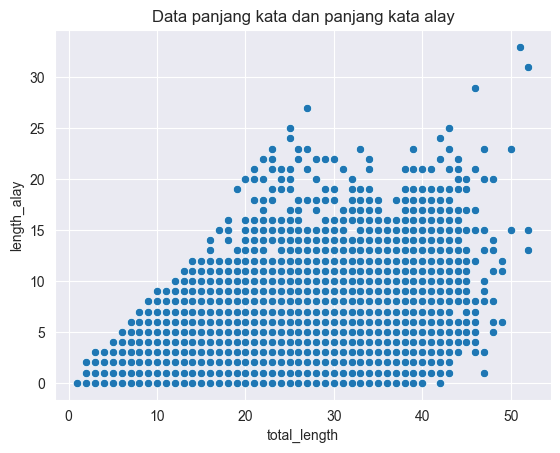

In [323]:

sns.set_style("darkgrid")
sns.scatterplot(data=df, x="total_length", y="length_alay")
plt.title('Data panjang kata dan panjang kata alay')
plt.show()

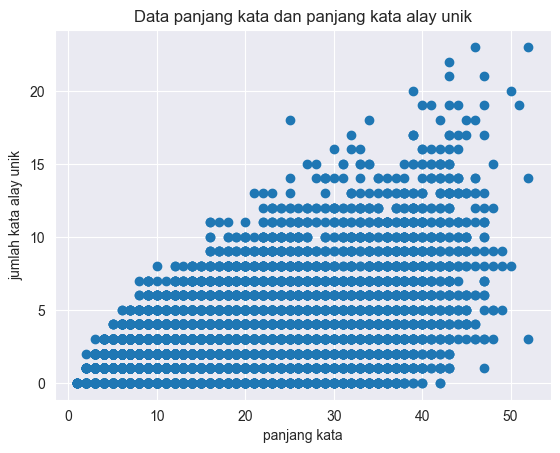

In [324]:
# membuat component figure dan axis
fig, ax = plt.subplots()


# memberikan data kedalam axis
ax.scatter(df['total_length'], df['length_alay_unique'])
plt.title('Data panjang kata dan panjang kata alay unik')
plt.xlabel('panjang kata')
plt.ylabel('jumlah kata alay unik')
plt.show()

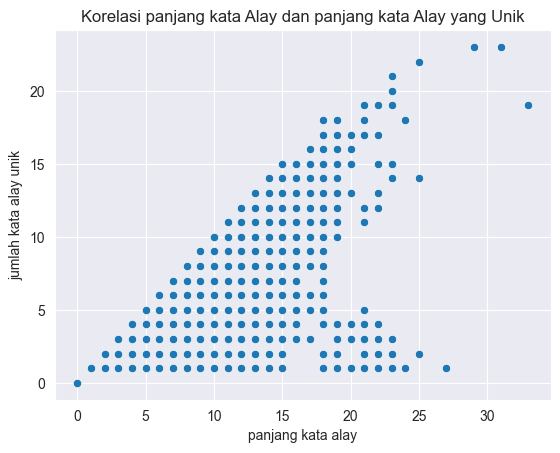

In [340]:


sns.scatterplot(data=df, x="length_alay", y="length_alay_unique")
plt.title('Korelasi panjang kata Alay dan panjang kata Alay yang Unik')
plt.xlabel('panjang kata alay')
plt.ylabel('jumlah kata alay unik')
plt.show()

### Histogram

Text(0.5, 1.0, 'Distribusi Panjang Kata')

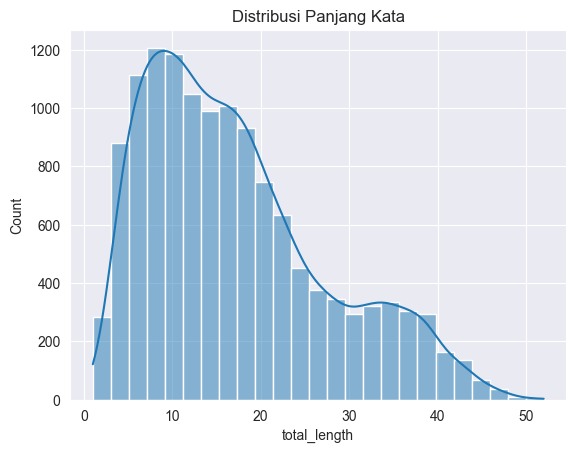

In [335]:

sns.histplot(data=df, x="total_length", kde=True, bins=25)
plt.title('Distribusi Panjang Kata')

Text(0.5, 1.0, 'Distribusi Panjang Kata Alay')

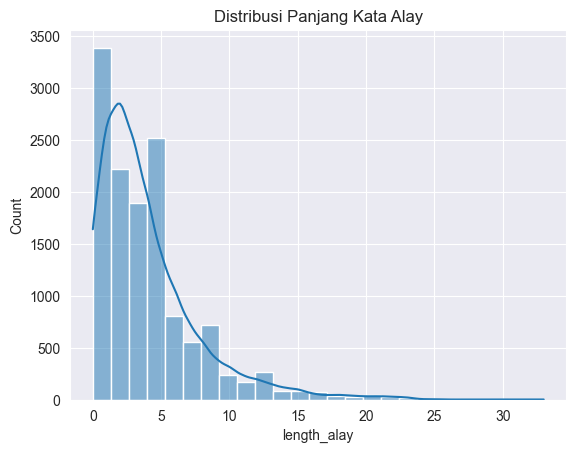

In [337]:
sns.histplot(data=df, x="length_alay", kde=True, bins=25)
plt.title('Distribusi Panjang Kata Alay')

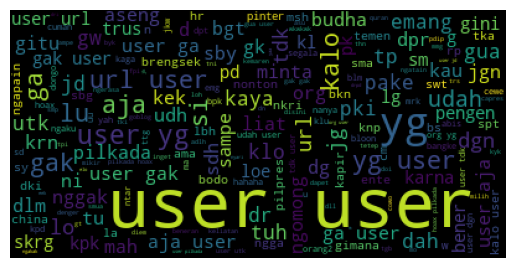

In [374]:
text_data_list = []
for text_list in df['text_alay']:
    data = ' '.join(text_list)
    text_data_list.append(data)

text = ' '.join(text_data_list)


wordcloud = WordCloud().generate(text)

# generate plot
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [390]:
text_data_list = []
for text_list in df['text_alay']:
    for text in text_list:
        text_data_list.append(text)


In [423]:
# Plot bar chart with data points
keys, counts = np.unique(text_data_list, return_counts=True)

# membuat dataframe untuk kata alay
alay_dataframe = pd.DataFrame({'kata_alay': keys, 'jumlah': list(counts)}, columns=['kata_alay', 'jumlah'])
# mengurutkan kata alay berdasarkan jumlah terbanyak
data_for_plot = alay_dataframe.sort_values(by='jumlah', ascending=False).head(10)
data_for_plot

,kata_alay,jumlah
7095,user,15385
7389,yg,2913
7088,url,819
1987,gak,713
1958,ga,712
147,aja,657
2818,kalo,512
6206,si,444
3558,lu,420
7003,udah,377


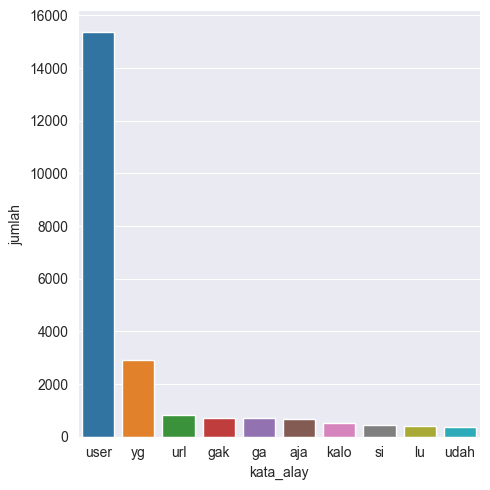

In [422]:
sns.catplot(data=data_for_plot, x='kata_alay',  y='jumlah',kind='bar')
plt.show()

Berdasarkan hasil analisa berdasarkan descriptive maupun dengan visualisasi dapat disimpulkan beberapa hal sebagai berikut:
- ada pengaruh penggunaan kata alay dengan banyaknya kata yang ditulis oleh pengguna media sosial. sehingga semakin banyak pengguna menulisakn kata maka akan semakin sering pengguna media sosial menggunakan kata alay yang bertujuan untuk menghemat waktu penulisan ataupun biar kelihatan kekinian.
- kata alay yang dapat dikatakan paling sering digunakan adalah kata "yg" merujuk pada "yang", diikuti kata "gak" dan "ga" merujuk "tidak", "aja" merujuk "aja" dan "kalo" merujuk "kalau".
- kata alay "user" dan "url" tidak saya kategorikan kata yang paling sering digunakan karena kata tersebut biasanya merupakan kata spam dan kata singkatan 


dari beberapa hasil analisa diatas maka pengguna media sosial di Inodonesia cenderung lebih sering menggunakan kata alay dalam penulisan text di platform media sosial hal tersebut dikarenakan penggunaan kata tersebut lebih ringkas daripada menggunakan bahasa indonesia yang baku sehingga mempercepat dalam penulisannya serta ada pengaruh istilah kekinian dalam bermedia sosial.